In [276]:
import os
import pickle
import numpy as np
import h5py
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from mne import create_info
from mne.io import RawArray

# --- User parameters ---
ROOT              = "/vol/cortex/cd3/pesaranlab/OCD_Mapping_Foundation"
PATIENT           = "Patient3"
DAY               = "day3"
BIG_TRIAL_IDX     = 0    # which interval in the big (day-level) pickle
MINI_TRIAL_IDX    = 0   # which interval in the mini pickle (small session)
TARGET_FS         = 500.0   # rate for downsampling and HDF5 sampling
ELEC_CSV          = os.path.join(ROOT, "original_data", "electrodes_all_subj3.csv")
SESSION_NAME      = "P3_D3_Tsymptom_provocation_SUPENNS001R01"

# File paths
MAT_PATH  = os.path.join(ROOT, "Matlab_data_processed", PATIENT, f"{DAY}.mat")
BIG_PKL   = os.path.join(ROOT, "processed_data", "labels", f"{PATIENT}_{DAY}_intervals_new.pkl")
MINI_PKL  = os.path.join(ROOT, "processed_data", "labels", f"{SESSION_NAME}.pkl")   
H5_PATH   = os.path.join(
    ROOT, "processed_data_upd", "processed_data", "ocd_symptom_provocation_unfiltered",
    f"{SESSION_NAME}.h5"
)



In [ ]:
# Cell 2 — Load MATLAB Trial

def load_matlab_trial(mat_path, trial_idx):
    try:
        m = loadmat(mat_path, struct_as_record=False, squeeze_me=True)
        ft = m.get("ftdata") or m.get("ftData")
        return ft.trial[trial_idx], float(ft.fsample)
    except NotImplementedError:
        with h5py.File(mat_path, "r") as f:
            grp = f.get("ftdata") or f.get("ftData")
            refs = grp["trial"][()]
            fs = float(np.array(grp["fsample"]).item())
            trials = [np.array(f[r]).T for r in refs.flatten()]
        return trials[trial_idx], fs

def downsample_data(data, orig_fs, target_fs):
    info = create_info(
        ch_names=[f"ch{i}" for i in range(data.shape[0])],
        sfreq=orig_fs,
        ch_types=["eeg"]*data.shape[0]
    )
    raw = RawArray(data, info)
    raw.resample(target_fs, npad="auto")
    return raw.get_data()


# def bipolar_reference(data, elec_csv=None):
#     """
#     No rereferencing: just return the raw data and generic channel names.
#     """
#     n_chans = data.shape[0]
#     chan_names = [f"ch{i}" for i in range(n_chans)]
#     return data, chan_names



"""traditional way to do this"""
def bipolar_reference(data, elec_csv):
    elec_df = pd.read_csv(elec_csv)
    names = elec_df["name"].astype(str).tolist()
    mask = [(names[i][:2] == names[i+1][:2]) and (names[i]!="")
            for i in range(len(names)-1)]
    contig = np.where(mask)[0]
    diff = data[1:,:] - data[:-1,:]
    return diff[contig], [names[i] for i in contig]







# def bipolar_reference(data, elec_csv):
#     """
#     Compute a simple bipolar montage by subtracting each adjacent pair of channels.
#     Reads the electrode CSV only to label each new channel.

#     """
#     # Load channel names
#     elec_df = pd.read_csv(elec_csv)
#     names = elec_df["name"].astype(str).tolist()

#     # Subtract each adjacent pair
#     diff = data[1:, :] - data[:-1, :]

#     # Build bipolar channel names from the CSV labels
#     chan_names = [f"{names[i+1]}-{names[i]}" for i in range(diff.shape[0])]

#     return diff, chan_names



def extract_interval(pkl_path, idx):
    with open(pkl_path, "rb") as f:
        iv = pickle.load(f)
    return float(iv.start[idx]), float(iv.end[idx])



def load_h5_segment(h5_path, start_sec, end_sec, fs):
    """
    Assumes the dataset always shaped (samples, channels).
    Extracts the window from start_sec to end_sec (in seconds) at sampling rate fs,
    and returns a NumPy array of shape (channels, samples).
    """
    with h5py.File(h5_path, 'r') as f:
        ieeg = f['ieeg/data']             # shape: (samples, channels)
        print("HD5 raw ieeg/data shape:", ieeg.shape)

        start_idx = int(start_sec * fs)
        end_idx   = int(end_sec   * fs)

        # slice out time window, then transpose
        seg = ieeg[start_idx:end_idx, :]  # (samples, channels)
        seg = seg.T                       # (channels, samples)

    return np.array(seg)



"""older way from my previous script"""
def compute_corr(mat_ds, h5_seg):
    """
    Compute channel×channel Pearson r between mat_ds and h5_seg
    by stacking and using np.corrcoef.
    Inputs (channels, time).
    """
    def ensure_chan_time(arr):
        # if rows > cols, assume (time, channels) → transpose
        if arr.shape[0] > arr.shape[1]:
            return arr.T
        return arr

    # 1) Ensure (channels, time)
    Y = ensure_chan_time(mat_ds)
    X = ensure_chan_time(h5_seg)

    # 2) Truncate to same time length
    T = min(Y.shape[1], X.shape[1])
    Y = Y[:, :T]
    X = X[:, :T]

    # 3) Stack channels
    Z = np.vstack([X, Y])  # shape = (n_hd5 + n_mat, T)

    # 4) Compute full correlation matrix
    C_full = np.corrcoef(Z)  # shape = (n_total, n_total)

    # 5) Slice out the cross‐block (HD5 vs MATLAB)
    n_hd5 = X.shape[0]
    return C_full[:n_hd5, n_hd5:]




In [278]:
# ## Cell 3 — Bipolar Reference & Downsample MATLAB Data

# 1) Load raw MATLAB trial and fs
big_mat, fs_big = load_matlab_trial(MAT_PATH, BIG_TRIAL_IDX)
print(f"Loaded MATLAB big trial #{BIG_TRIAL_IDX}: shape={big_mat.shape}, fs={fs_big:.1f}Hz")

#Bipolar & downsample
bip_diff, bip_chs = bipolar_reference(big_mat, ELEC_CSV)
mat_ds_Big = downsample_data(bip_diff, fs_big, TARGET_FS)

# """just for testing: no rereferencing"""
# raw_mat = big_mat  # no reref
# chan_names = [f"ch{i}" for i in range(raw_mat.shape[0])]
# mat_ds_big = downsample_data(raw_mat, fs_big, TARGET_FS)


print(f"Big trial DS: {mat_ds_Big.shape}, channels={len(bip_chs)}")


Loaded MATLAB big trial #0: shape=(248, 72000), fs=1200.0Hz
Creating RawArray with float64 data, n_channels=231, n_times=72000
    Range : 0 ... 71999 =      0.000 ...    59.999 secs
Ready.
Big trial DS: (231, 30000), channels=231


In [279]:
## Cell 4 — Extract Interval Times

# Day‑level interval (big)
start_big, end_big = extract_interval(BIG_PKL, BIG_TRIAL_IDX)
print(f"Big interval #{BIG_TRIAL_IDX}: {start_big:.3f}s → {end_big:.3f}s")

#mini session
start_min, end_min = extract_interval(MINI_PKL, MINI_TRIAL_IDX)
#start_min, end_min = (343.468, 403.468)  # manually set for testing
print(f"Mini interval #{MINI_TRIAL_IDX}: {start_min:.3f}s → {end_min:.3f}s")

Big interval #0: 205.488s → 265.488s
Mini interval #0: 205.488s → 265.488s


In [280]:
# Cell 5 — Load HDF5 Segment

# Extract mini HDF5 segment
hd5_min = load_h5_segment(H5_PATH, start_min, end_min, TARGET_FS)
print(f"HD5 segment shape: {hd5_min.shape}")  # should be (n_channels, n_samples)

hd5_min, hd5_chs = bipolar_reference(hd5_min, ELEC_CSV)
print(f"HD5 bipolar segment: {hd5_min.shape}")

HD5 raw ieeg/data shape: (1800400, 240)
HD5 segment shape: (240, 30000)


IndexError: index 240 is out of bounds for axis 0 with size 239

Correlation shape: (239, 247)


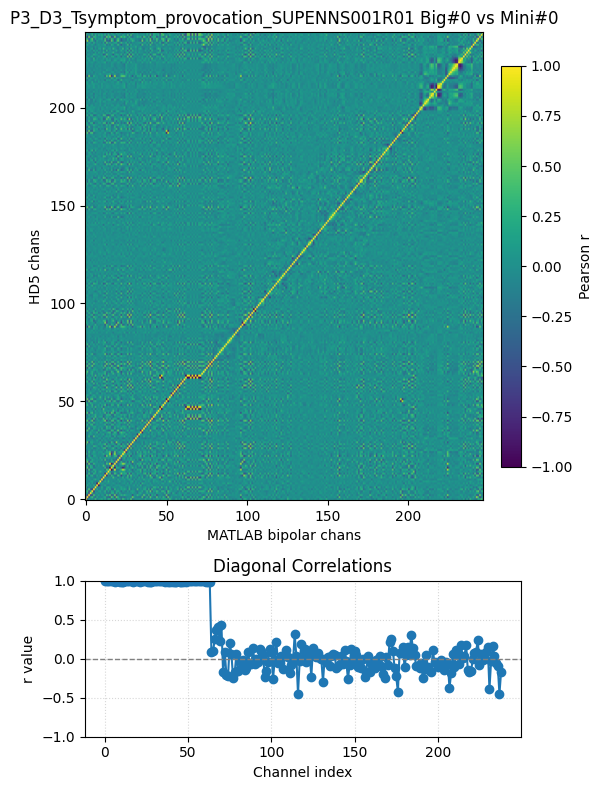

In [ ]:
# Cell 6 — Compute & Visualize Correlations

# Correlate MATLAB vs mini HDF5
corr_min = compute_corr(mat_ds_Big, hd5_min)
print(f"Correlation shape: {corr_min.shape}")

# Create a single figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'height_ratios': [3, 1]})

# Top subplot: heatmap of correlations
im = ax1.imshow(corr_min, origin="lower", aspect="auto", vmin=-1, vmax=1)
ax1.set_title(f"{SESSION_NAME} Big#{BIG_TRIAL_IDX} vs Mini#{MINI_TRIAL_IDX}")
ax1.set_xlabel("MATLAB bipolar chans")
ax1.set_ylabel("HD5 chans")
fig.colorbar(im, ax=ax1, label="Pearson r", fraction=0.046, pad=0.04)

# Bottom subplot: diagonal correlations
ax2.plot(np.diag(corr_min), marker="o", linestyle="-")
ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
ax2.set_title("Diagonal Correlations")
ax2.set_xlabel("Channel index")
ax2.set_ylabel("r value")
ax2.set_ylim(-1, 1)
ax2.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()